<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week19_deeplearning_nlp/ch19_6_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch19_6 seq2seq

이전 챕터에서 LSTM과 GRU를 이용하여 간단한 문장 분류 모델을 만들어 보았습니다. 이번 챕터에서는 이 RNN 모델들을 가지고 seq2seq라 불리는 구조로 모델을 구성하여 번역을 수행하는 모델을 만들어 보겠습니다.

현재 사용하는 LLM 모델들을 구성하는 기술들이 모두 번역 테스크에서 모티브를 얻었으므로, 간단히 기계 번역 모델을 학습시켜보면서 원리를 이해해보도록 하겠습니다.

## 사전 작업

### 디바이스 설정

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 데이터 셋 준비

번역 모델을 학습시키기 위해서는 원문과 번역문이 쌍으로 짝지어진 데이터 셋이 필요합니다. 이를 parallel corpus(병렬 코퍼스)라고 부릅니다. 미리 전처리 해놓은 데이터 셋을 불러오겠습니다.

In [4]:
import pandas as pd

train_df = pd.read_csv("./drive/MyDrive/dscamp_2023/translation_train.csv")
val_df = pd.read_csv("./drive/MyDrive/dscamp_2023/translation_val.csv")
test_df = pd.read_csv("./drive/MyDrive/dscamp_2023/translation_test.csv")

In [5]:
train_df

,kor,eng
0,"mslee가 부재중이셔서, 당신에게 연락드립니다.","since ms.lee is absence, i contacted you."
1,"아래 내용으로 테스트 호텔 지도화가 되었다고 했고, sso를 이용하여 가입 페이지에...",it says that test hotel mapping has been done ...
2,제인이 방에 들어오면 분위기가 바뀝니다.,the atmosphere changes when jane enters the room.
3,나는 네가 그 채팅 앱을 사용하는 것이 싫어.,i dislike you using that chatting app.
4,창의적인 아이디어를 통해 지역과 함께 발전하는 회사입니다.,it's a company growing with the community thro...
...,...,...
399995,그렇군요. 그런데 그날 오후에 서울 떠나서 다른 날로 일정을 잡을 수가 없습니다.,i see. but i cant schedule another date since ...
399996,그건 나에게 온 편지를 받기 위해서예요.,it is getting the letter which was sent to me.
399997,내 생각에는 silicone volume 값을 측정하는 화면만 있으면 될 것 같아.,"in my opinion, all we need is a screen for mea..."
399998,당신은 나를 충분히 안심 시켜 줬어요.,you relieved me enough.


In [6]:
val_df

,kor,eng
0,오늘 당신이 와주셔서 감사해요.,i'm very glad you've come today.
1,제가 더 저렴하게 줄 수 없는 대신 양말 한 켤레를 서비스로 줄게요.,i cannot give you a discounted price but i wil...
2,사용한 샘플은 중국에 있는 공장에서 제공된 것이 아니다.,the sample used was not provided by the factor...
3,"세안 후 스킨 사용 전, 이 제품을 적당량을 덜어 얼굴에 부드럽게 펴 바릅니다.",after washing the face and before using a tone...
4,"한 번도 잊은 적이 없었죠, 우리 마지막 순간.",i really never forgot our last moment.
...,...,...
98995,여기의 지문에서는 서양식의 옷이 운동하기에 더욱 적합하다고 언급해요.,the text here mentions that westernstyle cloth...
98996,우리의 지원 담당자가 당신의 요청을 검토한 후 개인적으로 연락을 줄 것입니다.,a support manager will be reviewing your reque...
98997,이 비즈니스가 성사될 수 있도록 좀 더 적극적으로 g4s를 푸쉬 해주기를 바랍니다.,please push g4s a little more so that this bus...
98998,밤에 가는 데 얼마나 걸려요?,how long does it take to get there at night?


In [7]:
test_df

,kor,eng
0,정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?,really? so did you have a good time? did you e...
1,"만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?","if our life is but a dream, why do we have an ..."
2,우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.,"as we could only use free wifi at the airport,..."
3,그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.,the place where we can enjoy the bun cha the m...
4,나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.,i can't draw very well but i like to draw.
...,...,...
995,내가 보낸 우편물을 확인해 봤어요?,did you check the mail i sent?
996,나는 바로 유치원으로 취직을 했습니다.,i got a job at a kindergarten immediately.
997,고맙지만 도와주시지 않아도 돼요.,"thank you, but i dont need help."
998,오늘 우리 3명은 커피숍을 소개하도록 하겠습니다.,"we, three members, will introduce coffee shops..."


### tokenizer 준비

미리 학습시켜놓은 tokenizer를 불러오겠습니다.

In [8]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.7 MB/s eta 0:00:00


In [9]:
from tokenizers import Tokenizer


kor_tokenizer = Tokenizer.from_file("./drive/MyDrive/dscamp_2023/translation_kor_tokenizer.json")
eng_tokenizer = Tokenizer.from_file("./drive/MyDrive/dscamp_2023/translation_eng_tokenizer.json")

In [10]:
kor_output = kor_tokenizer.encode("나는 학생입니다")
print(kor_output.tokens)
print(kor_output.ids)

eng_output = eng_tokenizer.encode("i am a student")
print(eng_output.tokens)
print(eng_output.ids)

['나는', '학생', '##입니다']
[3556, 3862, 3555]
['i', 'am', 'a', 'student']
[27, 233, 19, 1412]


## seq2seq 기본 이론



### 모델 구조
sequence to sequence의 약자로, 입력으로 문장이 들어오고 출력으로 문장을 내보내는 테스크입니다. 기계 번역이 대표적인 예시입니다. 우리는 GRU를 기반으로 한국어를 영어로 번역하는 모델을 만들어보고자 합니다. 전반적인 구조는 아래와 같습니다.

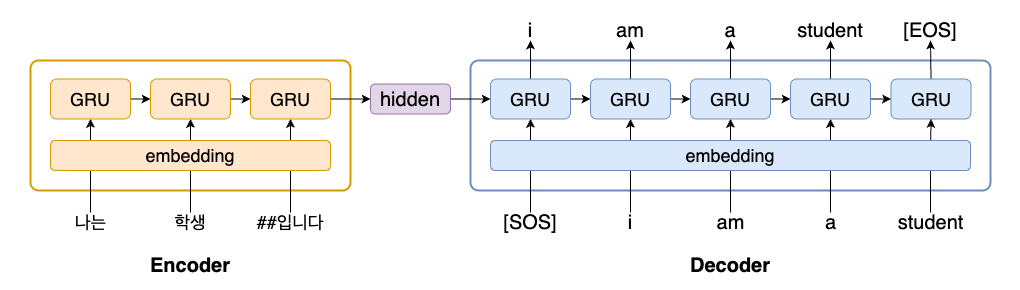

seq2seq 모델은 크게 encoder와 decoder로 구성됩니다. encoder는 입력 텍스트로부터 의미를 추출하는 역할을 합니다. 먼저 입력 문장으로부터 임베딩을 추출하고, GRU를 통과하여 마지막 단계의 hidden state를 추출하여 decoder로 넘겨줍니다.

decoder는 입력 문장 정보를 가지고 번역 텍스트를 출력하는 역할을 수행합니다. encoder로부터 전달받은 hidden state를 초기값으로 사용하여 GRU을 통과합니다. 이 떄, 문장의 끝을 나타내는 [EOS] 토큰이 나올 때까지 계속 반복해줍니다.


### teacher forcing

decoder 부분을 보시면 라벨에 해당하는 번역 텍스트가 입력으로 들어가는 부분이 보입니다. 이는 학습을 더 빠르게 진행시키기 위해 사용하는 teacher forcing(교사 강요) 기법입니다. 이전 시점에서의 출력 값을 decoder에 다시 입력으로 넣지 않고, 실제 라벨 값을 입력해주는 것입니다.

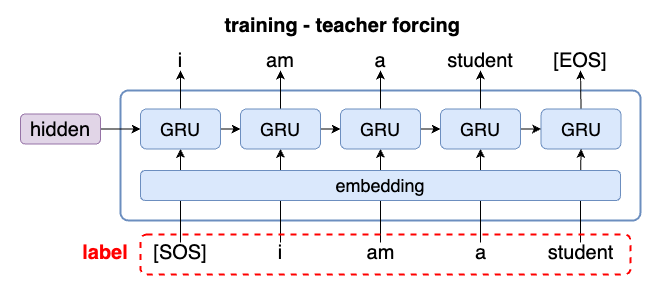

이렇게 하는 이유는 모델이 적절히 학습되지 않은 상태에서 이전 예측 값을 다음 셀의 입력으로 사용하면 모델 학습이 어렵기 때문입니다. 이전 시점에 잘못 예측을 했더라도, 실제 라벨을 넣어줘서 다음 셀에서 모델 학습이 일어날 수 있도록 도와줍니다.

교사 강요를 구현하기 위해서 decoder로 넣어주는 번역문 텍스트의 맨 앞에 문장의 시작을 의미하는 [SOS] 토큰을 넣어주어야 합니다.

## Dataset, DataLoader


병렬 코퍼스에 맞는 dataset과 dataloader를 작성해줍니다. 이 때, collate_fn에서 pack_padded_sequence 시에 사용할 문장별 토큰 길이도 리턴해주도록 합니다. 그리고 teacher forcing 구현에 필요하므로, 번역문 텍스트에는 맨 앞에 [SOS] 토큰을 붙여주겠습니다.

### Dataset

In [11]:
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, corpus_df):
        self.corpus_df = corpus_df

    def __len__(self):
        return len(self.corpus_df)

    def __getitem__(self, idx):
        row = self.corpus_df.iloc[idx]
        src = row["kor"]
        tar = row["eng"]
        return src, tar

In [12]:
train_dataset = CustomTextDataset(train_df)
val_dataset = CustomTextDataset(val_df)
test_dataset = CustomTextDataset(test_df)

In [13]:
train_dataset[0]

('mslee가 부재중이셔서, 당신에게 연락드립니다.', 'since ms.lee is absence, i contacted you.')

### DataLoader

데이터 로더는 데이터 셋으로부터 한국어와 영어 문장을 가져와서, 총 3가지 텐서를 리턴해주어야 합니다.
- src_padded: encoder에 입력으로 들어갈 한국어 문장 텐서
- tar_in_padded: teacher forcing을 위해 decoder에 입력으로 들어갈 영어 문장 텐서
- tar_out_padded: decoder가 제대로 번역을 수행했는지 비교할 영어 문장 텐서

먼저 문장을 토큰화하는 작업부터 살펴보겠습니다.

In [26]:
import torch

MAX_TOKENS = 256
BATCH_SIZE = 256

In [27]:
vocabs = kor_tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]
sos_token = vocabs["[SOS]"]
eos_token = vocabs["[EOS]"]

In [28]:
def tokenize(text, is_korean=True):
    if is_korean:
        tokens = kor_tokenizer.encode(text).ids
    else:
        tokens = eng_tokenizer.encode(text).ids
    tokens = tokens[:MAX_TOKENS]
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

In [29]:
tokens = tokenize("[SOS]i am a student", is_korean=False)
print(tokens)

tensor([   2,   27,  233,   19, 1412])


In [30]:
tokens = tokenize("i am a student[EOS]", is_korean=False)
print(tokens)

tensor([  27,  233,   19, 1412,    3])


collate_fn에서 해야할 일은 크게 3가지입니다.
- 원문 텍스트 토큰화 하고 패딩 채우기
- 번역문 텍스트 토큰화하고, decoder input앞에 [SOS] 토큰, decoder output 뒤에 [EOS] 토큰 붙여주기
- 각각 토큰 개수 세서 같이 리턴해주기

In [80]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    src = [x[0] for x in batch]
    tar = [x[1] for x in batch]

    # 1. 토큰화 하기, tar_in과 tar_out에는 각각 [SOS], [EOS] 추가
    src_tokens = [tokenize(x, is_korean=True) for x in src]
    tar_in_tokens = [tokenize(f"[SOS]{x}", is_korean=False) for x in tar]
    tar_out_tokens = [tokenize(f"{x}[EOS]", is_korean=False) for x in tar]

    # 2. padding 채우기
    src_padded = pad_sequence(src_tokens).to(device)
    tar_in_padded = pad_sequence(tar_in_tokens).to(device)
    tar_out_padded = pad_sequence(tar_out_tokens).to(device)

    # 3. token 개수 세기
    src_lengths = [len(x) for x in src_tokens]
    tar_lengths = [len(x) for x in tar_in_tokens]
    return src_padded, tar_in_padded, tar_out_padded, src_lengths, tar_lengths

In [81]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [82]:
train_iterator = iter(train_dataloader)
batch = next(train_iterator)
src_padded, tar_in_padded, tar_out_padded, src_lengths, tar_lengths  = batch

In [83]:
tar_in_padded

tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [554,  27, 238,  ..., 151, 124,  27],
        [ 97,   5,  87,  ..., 109, 280, 539],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]], device='cuda:0')

In [84]:
tar_out_padded

tensor([[ 554,   27,  238,  ...,  151,  124,   27],
        [  97,    5,   87,  ...,  109,  280,  539],
        [ 128,   31, 1645,  ...,   87,  209,  209],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]], device='cuda:0')

## Encoder 작성하기

먼저 encoder를 구현해보겠습니다. 이는 한국어 문장 토큰을 전달받아서 임베딩을 추출합니다. 그 다음 마지막 hidden state를 리턴합니다. 다이어그램에는 GRU 층이 하나로 표시되었지만, 실제로는 N_LAYER 값 만큼 LSTM 층이 쌓여있습니다.

그리고 encoder의 경우 bi-directional 옵션을 사용할 수 있습니다. 다만, decoder의 경우엔 bi-directional 사용이 불가해, decoder에 hidden state를 넘겨주기 전에 linear layer를 한번 통과시켜주어 차원을 맞춰주어야 합니다.

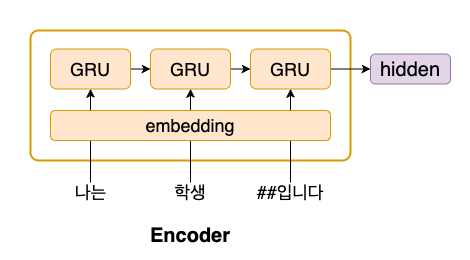

### Encoder 클래스 구현

In [85]:
import torch.nn as nn

VOCAB_SIZE = 8000
EMBEDDING_DIM = 256
HIDDEN_UNITS = 256
EMBED_MAX_NORM = 1
NUM_LAYERS = 1
DROPOUT = 0.5
BIDIRECTIONAL = True

In [94]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.5,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x, lengths):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, lengths, enforce_sorted=False)
        padded_outputs, hidden = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
            hidden = hidden.unsqueeze(0)
        return hidden

In [95]:
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_UNITS,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [96]:
src_padded.shape, len(src_lengths)

(torch.Size([38, 256]), 256)

In [97]:
!pip install torchinfo

In [98]:
from torchinfo import summary

summary(encoder)

Layer (type:depth-idx)                   Param #
Encoder                                  --
├─Embedding: 1-1                         2,048,000
├─GRU: 1-2                               789,504
├─Dropout: 1-3                           --
├─Linear: 1-4                            131,328
Total params: 2,968,832
Trainable params: 2,968,832
Non-trainable params: 0

In [99]:
encoder

Encoder(
  (embedding): Embedding(8000, 256)
  (rnn): GRU(256, 256, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=256, bias=True)
)

### Encoder 동작 확인

배치 하나만 흘려보내서 encoder가 제대로 hidden state와 cell state를 리턴해주는지 확인해보겠습니다.

In [100]:
hidden = encoder(src_padded, src_lengths)

In [101]:
hidden.shape

torch.Size([1, 256, 256])

## Decoder 작성하기
encoder로부터 시작 hidden state를 전달받습니다. embedding, GRU 구조는 encoder와 동일합니다.

GRU의 각 스텝별 output을 Fully Connected Layer를 한번 통과시켜 예측 토큰 값을 가져옵니다. 나중에 이 값들에 softmax를 적용한 뒤, 실제 라벨과 비교하여 cross entropy loss를 계산하여 모델을 학습시키게 됩니다.

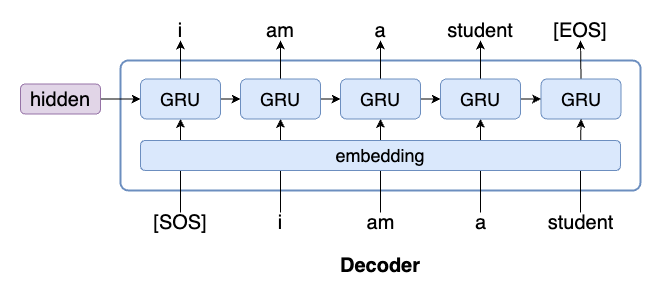

### Decoder 클래스 구현

decoder의 경우, bidirectional=False로 설정해주어야만 합니다. 왜냐하면 번역할 문장을 모르는 상태에서 역순으로 hidden state 값을 흘릴 수 없기 때문입니다.

In [102]:
from torch.nn.utils.rnn import pad_packed_sequence


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.5,
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, hidden):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, lengths, enforce_sorted=False)

        # rnn 호출 시에 encoder로부터 전달받은 hidden, cell을 넣어주면 됩니다.
        packed_output, hidden = self.rnn(packed_embedded, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_output)
        prediction = self.dropout(self.fc(outputs))
        return prediction, hidden

In [103]:
decoder = Decoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_UNITS,
    num_layers=NUM_LAYERS,
).to(device)

In [104]:
decoder

Decoder(
  (embedding): Embedding(8000, 256)
  (rnn): GRU(256, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=8000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [105]:
summary(decoder)

Layer (type:depth-idx)                   Param #
Decoder                                  --
├─Embedding: 1-1                         2,048,000
├─GRU: 1-2                               394,752
├─Linear: 1-3                            2,056,000
├─Dropout: 1-4                           --
Total params: 4,498,752
Trainable params: 4,498,752
Non-trainable params: 0

### Decoder 동작 확인

배치 하나만 흘려보내서 encoder가 제대로 hidden state와 cell state를 리턴해주는지 확인해보겠습니다.

In [106]:
prediction, hidden = decoder(tar_in_padded, tar_lengths, hidden)

In [107]:
prediction.shape, hidden.shape

(torch.Size([39, 256, 8000]), torch.Size([1, 256, 256]))

## Seq2Seq 작성하기

앞서 작성한 encoder와 decoder를 전달받아서 seq2seq 로직을 처리하는 클래스 작성해보겠습니다.

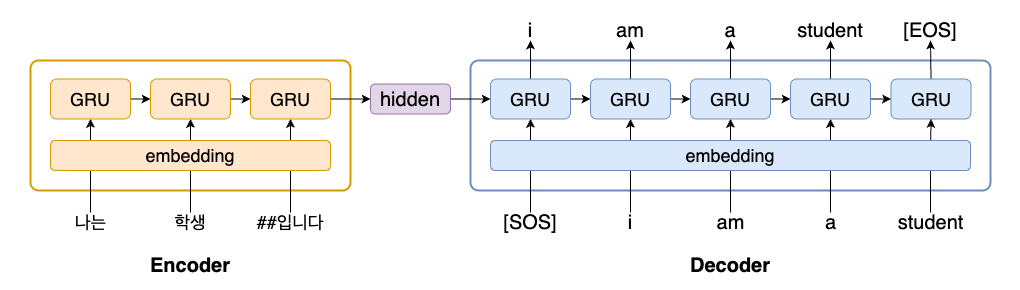

### Seq2Seq 클래스 구현

In [108]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src_padded, src_lengths, tar_in_padded, tar_lengths):
        hidden = self.encoder(src_padded, src_lengths)
        prediction, hidden = self.decoder(tar_in_padded, tar_lengths, hidden)
        return prediction

In [109]:
model = Seq2Seq(encoder, decoder)

### Seq2Seq 동작 확인

In [110]:
prediction = model(src_padded, src_lengths, tar_in_padded, tar_lengths)

In [111]:
prediction.shape

torch.Size([39, 256, 8000])

## inference

모델이 번역을 제대로 수행하는지 중간 중간에 확인하기 위한 코드입니다. teacher forcing을 적용하지 않고, 이전 시점에 예측 결과로 나온 토큰을 다음 시점 입력으로 전달합니다. 이러한 방식을 greedy decoding이라고 부릅니다.

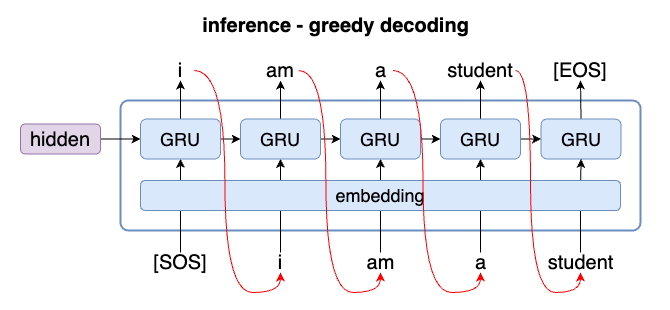

### Greedy Decoding

먼저 greedy decoding을 수행하는 함수부터 작성해보겠습니다. 텐서 연산이 상당히 복잡합니다만, 이전 시점의 예측 결과를 다음 시점에 입력으로 사용한다는 것만 기억하시고 넘어가시면 됩니다.

In [120]:
MAX_SEQUENCE_LENGTH = 30

def greedy_decoding(model, sentence):
    model.eval()
    tokens = tokenize(sentence, is_korean=True)
    src_in = tokens.unsqueeze(-1).to(device)
    src_lengths = [len(tokens)]
    tar_in = torch.tensor([[sos_token]], dtype=torch.long).to(device)
    tar_lengths = [1]

    with torch.no_grad():
        hidden = model.encoder(src_in, src_lengths)
        results = []
        for i in range(MAX_SEQUENCE_LENGTH):
            prediction, hidden = model.decoder(tar_in, tar_lengths, hidden)
            # sequence length, batch size 모두 1이므로 의미 없는 차원 제거
            prediction = prediction.squeeze()
            # top1 예측 결과 저장 및 EOS 토큰일 경우 인퍼런스 중지
            top1 = prediction.argmax()
            results.append(top1.item())
            if top1 == eos_token:
                break
            # 이전 시점의 출력값을 다음 시점의 입력 값으로 사용
            tar_in = torch.tensor([[top1]], dtype=torch.long).to(device)
    translated = eng_tokenizer.decode(results)
    return translated

### inference 동작 확인

greedy decoding이 제대로 동작하는지 샘플 데이터 셋으로 확인해보겠습니다. 학습을 진행하지 않았기 때문에 번역을 제대로 수행하지 못합니다.

In [125]:
def inference_samples(model, samples):
    for kor, eng in samples.values:
        translated = greedy_decoding(model, kor)
        print("kor:", kor)
        print("eng:", eng)
        print("translated:", translated)
        print("===========================================\n")

In [127]:
samples = test_df[:5]
inference_samples(model, samples)

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: union automatic baek 120 clin ##iest plays responsible ##rim near sadness se ang ##wer designated ##here threw examine transactions mo decl ##li volley two humid gim mom ##cc ##gan ##ac

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: ##gers ##ghter ey contem complaints spin necessary treat ##00 ##very ##very ##gg neckl ##abled paul 16th ##come physically revision ##nam pulled fin sl barbe dess vel socks current ash buck

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: ring ##eters theat november cath le fatigue divor goods ##gan anybody z chem perm mer discussing ine ##iments ##ature necessary treat treat ##00 get narrow ##ades park button require ##oted

kor

## 학습시키기
이제 준비는 끝났습니다. seq2seq 한국어 영어 번역 모델을 학습시켜 보겠습니다. 🚀🚀


### train, validate

In [112]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [115]:
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm

from torchtext.data.metrics import bleu_score


def train_model(model, epoch):
    model.train()
    loss_list = []

    pbar = tqdm(total=len(train_dataloader), position=0, leave=True)
    for data in train_dataloader:
        src_padded, tar_in_padded, tar_out_padded, src_lengths, tar_lengths = data
        outputs = model(src_padded, src_lengths, tar_in_padded, tar_lengths)
        probs = outputs.view(-1, outputs.shape[-1])
        labels = tar_out_padded.view(-1)

        loss = criterion(probs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        # gradient 폭발을 막아주는 장치
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        pred = torch.argmax(probs, dim=1)
        pbar.set_description(f"[Epoch {epoch}] TRAIN loss: {round(loss.item(), 4)}")
        pbar.update()
    return get_mean(loss_list)

In [116]:
def validate_model(model, epoch):
    model.eval()
    loss_list = []

    pbar = tqdm(total=len(val_dataloader), position=0, leave=True)
    for data in val_dataloader:
        src_padded, tar_in_padded, tar_out_padded, src_lengths, tar_lengths = data

        with torch.no_grad():
            outputs = model(src_padded, src_lengths, tar_in_padded, tar_lengths)
            probs = outputs.view(-1, outputs.shape[-1])
            labels = tar_out_padded.view(-1)

            loss = criterion(probs, labels)
            loss_list.append(loss.item())

        pbar.set_description(f"[Epoch {epoch}] VAL loss: {round(loss.item(), 4)}")
        pbar.update()
    return get_mean(loss_list)

In [133]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss = train_model(model, epoch+1)
        val_loss = validate_model(model, epoch+1)
        inference_samples(model, samples)
        logs["train_loss"].append(train_loss)
        logs["val_loss"].append(val_loss)
    return logs

In [134]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    plt.plot(logs["train_loss"], label="train")
    plt.plot(logs["val_loss"], label="val")
    plt.legend()
    plt.set_title("loss")

### 하이퍼 파라미터 셋팅

In [135]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
epochs = 10
learning_rate = 0.001

### 학습 및 결과 시각화

In [136]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? i ' m really sorry , but i ' m really sure that you can ' t have any time ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why are you going to do this time , and why are you going to be a good idea ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we couldn ' t have a car in the morning , but we can ' t go to the station .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: the most popular in the country is the most popular .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i don ' t know why i don ' t know what i ' m not good .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? i ' m really sorry . i ' m looking forward to the product .

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why are you going to be a good relationship with our family ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we have to go to the airport to the airport , but we can ' t go to the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: i can ' t eat the most popular in korea .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i don ' t like to eat a good ##look .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? how much is it ? i ' m really sorry for you .

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: if we were all the same year , why are you going to be a new person ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we ' ve been able to go to the airport , but we can ' t find it at the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: the best is the most popular in korea .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like to see the fact that i ' m not good at the same time .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? i ' m really glad to eat a lot of time .

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why are you going to be a person who lives in our lives ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we booked a parking lot of luggage , but we can ' t find it at the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: there is a place where you can enjoy the korean food .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like a picture of the picture of the picture .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? it ' s really good . what ' s the time you really liked ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why is it true if we have a dream of our life ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we ' ve been here to go to the airport , so we can ' t find it at the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is a place where you can enjoy the korean food .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like the picture of the picture , but i don ' t know it .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? it ' s really good . what should i do ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: if we were in our life , why don ' t we have a dream of our life ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we ' re going to find a flight attendant , so we can ' t find it at the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is a place where you can enjoy the most .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like the picture of the picture , but i don ' t know .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? it ' s really good . how long it was really delicious ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: if we are all of our dreams , why do you have a dream to be a dream ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we ' re going to find a bus to find the airport to get to the airport to get to the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is the best place where you can enjoy the most .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like painting , but i don ' t like it .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? thank you for your good time ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why do you want to be a good person in our life ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we ' re going to go to the airport to find a place where we can find the airport where we can find it .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is the best food in korea .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like drawing ##s but i don ' t like it .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? how much did you enjoy it ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why do you have a dream to do if we have a dream of all the time ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we only have to wait for a pickup service for a long time to get to the airport .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is a korean restaurant where you can enjoy the most .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like the picture of the painting but i can ' t see it .



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

kor: 정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?
eng: really? so did you have a good time? did you eat delicious food?
translated: really ? how long did you enjoy it ?

kor: 만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?
eng: if our life is but a dream, why do we have an itchy palm like this?
translated: why do you think we ' re going to be a dream of our dream if we have a dream of this challenge ?

kor: 우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.
eng: as we could only use free wifi at the airport, we searched the way to our guesthouse in advance.
translated: we came to the airport to use the airport to get to the airport , so we can use it .

kor: 그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.
eng: the place where we can enjoy the bun cha the most.
translated: it is a place where you can enjoy the food .

kor: 나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.
eng: i can't draw very well but i like to draw.
translated: i like to draw a picture but i don ' t like it .



AttributeError: ignored

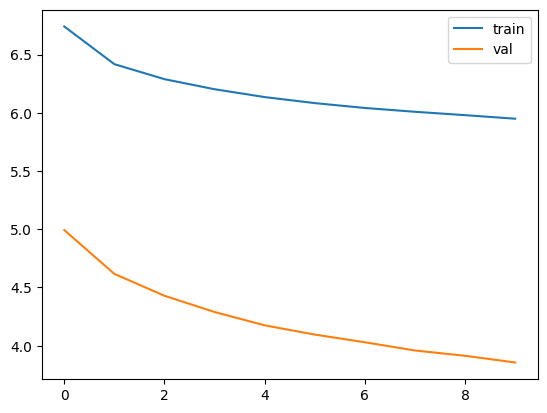

In [137]:
logs = train_validate_model(model)
plot_logs(logs)

## 테스트 및 저장

### 문장 번역해보기

학습된 모델에 임의의 문장을 넣어서 제대로 번역되는지 확인해보겠습니다. 구체적인 번역 모델 성능 평가는 다음 챕터에서 진행하겠습니다.

In [142]:
greedy_decoding(model, "배도 고픈데 저랑 같이 점심 먹을래요?")

"i ' m hungry , so can i eat lunch together ?"

### 모델 저장

In [143]:
savepath = "./drive/MyDrive/dscamp_2023/translation_weight.pth"
torch.save(model.state_dict(), savepath)

## 정리

이번 시간에는 기계 번역 분야에서 혁신을 일으킨 seq2seq 모델에 대해서 배워보았습니다. 이 모델을 기점으로 딥러닝을 이용한 자연어 처리가 급속도로 발전하게 되며, 이후에 등장하는 Attention 개념의 초석이 됩니다.

모델을 학습시키는 코드의 구조는 상당히 복잡하지만, 모델 구조는 매우 단순하였습니다. 너무 디테일에 집착하지 말고, encoder와 decoder로 이루어진 전반적인 구조만 이해하고 넘어가겠습니다.